In [1]:
#! pip install pipreqs

In [2]:
#! pipreqs --encoding=utf-8 c:/Users/Diya/Documents/GItHub/DELTA_Element3

# 0. Import Libraries 

In [1]:
# For preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from Data_Preprocess import DataPreprocessor

from Classification_Scores import ClassificationEvaluator

from Data_Augmentation import DataAugmentor

# For VaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# For RNN model 
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import FastText
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.metrics import AUC, Precision, Recall

# For DistilBERT
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, TextClassificationPipeline, TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# 1. Data Preprocessing

### 1.1. Importing and understanding the data.

In [3]:
# Importing the train and test datasets
train_df = pd.read_parquet('btc_tweets_train.parquet.gzip').reset_index()
test_df = pd.read_parquet('btc_tweets_test.parquet.gzip').reset_index()

In [4]:
# Running a few checks to understand the datasets (shape, empty tweets, info and head)
def df_info(df):
    print(f'shape of the datafreme: {df.shape}')
    print(f'Number of empty values: {df.isnull().sum().sum()}')
    print(df.info())
    print(df.head())

In [5]:
df_info(train_df)

shape of the datafreme: (2438, 6)
Number of empty values: 3000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2438 entries, 0 to 2437
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0.1     2438 non-null   int64  
 1   Unnamed: 0       1438 non-null   float64
 2   content          1438 non-null   object 
 3   username         1438 non-null   object 
 4   sentiment        2438 non-null   int64  
 5   cleaned_content  2438 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 114.4+ KB
None
   Unnamed: 0.1  Unnamed: 0  \
0             0       443.0   
1             1         NaN   
2             2      1366.0   
3             3       259.0   
4             4         NaN   

                                             content       username  \
0  $BTC dominance about to dump, finally somethin...  TrueGemHunter   
1                                                NaN            N

In [5]:
df_info(test_df)

shape of the datafreme: (500, 6)
Number of empty values: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet ID          500 non-null    int64 
 1   hashtags          500 non-null    object
 2   content           500 non-null    object
 3   username          500 non-null    object
 4   user_displayname  500 non-null    object
 5   sentiment         500 non-null    bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 20.1+ KB
None
              tweet ID                                           hashtags  \
0  1641861708246552576                                      [crypto, btc]   
1  1641861783898972167                                 [Bitcoin, Bitcoin]   
2  1641862152532418562  [Giveaway, BTC, SolanaGiveaways, Giveaway, Air...   
3  1641862338369183753  [EOS, USDT, BTC, crypto, Bitcoin, etherium, Bi...   
4  1641862430434131

In [6]:
# Dropping the unnecessary features.
# Note: Although 'hashtags' feature is removed, hashtags in the tweet are differently handled in DataPreprocess class
train_df = train_df.drop(['tweet ID', 'user_displayname', 'hashtags'], axis=1)
test_df = test_df.drop(['tweet ID', 'user_displayname', 'hashtags'], axis=1)

In [6]:
# Converting the sentiment labels from bool to int
train_df['sentiment'] = train_df['sentiment'].astype(int)
test_df['sentiment'] = test_df['sentiment'].astype(int)

The DataPreprocessor class imported from DataPreprocess.py is an all in one class that has various methods required for processing the raw tweets before feeding them to any model. Methods are defined individually to foster flexibility, allowing customization of data perprocessing steps per the advantages and limitations of the specific model. At the same time, doing so improves both, redability of the code and understandability of the underlying process.

Below is the description of each method briefing the logic and reason.

1. **Remove_spam_content( )**<br>
Tweets that are highly similar in their content (similarity>80%>) are removed. Bots often generate repeated content. I went through filtered out tweets and noticed that almost all of them were irrlevent to bitcoin and crypto.

2. **Remove_hashtags( )**<br> 
Initially, I removed all hashtags from tweets, but later realized that complete removal is inappropriate as it causes relevant data loss. *This method retains top 30 most frequent hashtags as all of them are related to bitcoin and crypto. Noticed significant improvement in classification after its implementation.*

3. **Remove_link( )**<br>
Removes link(s) from the tweet, if any.

4. **Remove_whitespace_html( )**<br>
Removes all the whitespace and HTML tags from the tweet.

5. **Remove_emojis( )**<br>
Similar t hashtahs, but *only expression and emotion related emojis are retained while all others removed. The retained emojis are then demojized as the add sentiment to the tweet.*

6. **Clean( )**<br>
This method removes punctuations and stop words and applies lemmatization. *It's wrth to note that a significant performance improvement is observed when numbers and '$' character is retained in the tweet. This makes sense as the tweets are relaed to bitcoin and many of them have its price mentioned.*


### A few trials

In [8]:
# def extract_special_characters(text):
#     # Regular expression to match special characters
#     return re.findall(r'[^a-zA-Z0-9\s]', text)

# # Extract special characters from the selected column (e.g., 'content')
# df = train_df.copy()
# df['special_chars'] = df['content'].apply(extract_special_characters)

# # Flatten the list of special characters and count their frequency
# special_chars_list = df['special_chars'].sum()
# special_chars_count = Counter(special_chars_list)

# # Get the most common special characters
# most_common_special_chars = special_chars_count.most_common()

# # Display the results
# for char, count in most_common_special_chars:
#     print(f"'{char}': {count}")

In [9]:
# def extract_emojis(text):
#     return ''.join(char for char in text if char in emoji.EMOJI_DATA)

# # Extract emojis from the selected column (e.g., 'content')
# #column_to_use = 'cleaned_content' if 'cleaned_content' in df.columns else 'content'
# df = train_df.copy()
# df['emojis'] = df['content'].apply(extract_emojis)

# # Flatten the list of emojis and count the frequency of each emoji
# emoji_list = df['emojis'].sum()
# emoji_count = Counter(emoji_list)

# # Get the top 50 most used emojis
# top_50_emojis = emoji_count.most_common(200)

# # Display the results
# for emoji_char, count in top_50_emojis:
#     print(f"{emoji_char}: {count}")


**NOTE: both the cleaned datasets above are still imbalanced with True values largly outnumbered than False. The imbalance needs to be taken care of by assigning class weights dring model training.**

# 2. Benchmark: vaderSentiment Sentiment Dictionary

For sentiment analysis using VADER, it's best to apply VADER to the raw, uncleaned text to leverage its strengths in handling informal language, punctuation, and emojis. However, when it comes to Links, it is best to remove them. Links are irrelevent to the sentiment and could add unnecessary noise, potentially influencing the sentiment. Also after multiple iterations, it was obseved that most of the emojis are adding no value but noise. Hence only expression specific emojis are retained and ret all are removed. 

The preprocessing flow for vaderSentiment
- Remove spam tweets
- Remove links
- Remove unnecessary hashtags
- Remove whitespace and HTML tags
- Remove unnecessary emojis
- Then apply vader sentiment dictionary on the cleaned tweets

### 2.1. Getting the dataset ready for VaderSentiment

In [12]:
vader_test_df = test_df.copy()

# Initialize the DataPreprocessor class for vaderSentiment
vader_test_datapreprocessor = DataPreprocessor(df=test_df, content_column='content')

In [13]:
# Getting the dataset ready by removing spam, unnecessary hashtags, links, whitespace, HTML tags and emojis
vader_test_df = vader_test_datapreprocessor.preprocess( remove_spam=True,
                                                        remove_hashtags=True, 
                                                        remove_link=True, 
                                                        remove_whitespace_html=True, 
                                                        remove_emoji=True )

c:\Users\Diya\Documents\GItHub\DELTA_Element3\DataPreprocess.py:114: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tweet = BeautifulSoup(tweet, 'html.parser').get_text()


In [14]:
vader_test_df.head()

,content,username,sentiment,cleaned_content
0,#crypto $crypto #btc \nI am Chinese crypto alp...,huahuayjy,1,#crypto $crypto #btc I am Chinese crypto alpha...
1,#Bitcoin would have to fall another 80% to rea...,luke_broyles,0,#Bitcoin would have to fall another 80% to rea...
2,#Giveaway $1000 Matic in 3Days\n\n🏆To win\n1️⃣...,cryptomarsdo,1,#Giveaway $1000 Matic in 3Days To win keycap_...
3,Up or Down?\n\n!!! $EOS #EOS !!!\n\nVS\n\n$USD...,andreyukrnet,1,Up or Down? !!! $EOS !!! VS $USDT #USDT AND $B...
4,Mid Day Mix-up is LIVE! Never know who might s...,JustAman04,1,Mid Day Mix-up is LIVE! Never know who might s...


In [15]:
# look over an example to see if the tweets are cleaned as expected
index = 43
vader_test_df['content'].iloc[index], vader_test_df['cleaned_content'].iloc[index], vader_test_df['sentiment'][index]

('🚨BREAKING NEWS🚨\n\nTron founder Justin Sun ( @justinsuntron ) makes a bold move and offers to purchase ALL 41,500 #Bitcoin from the US Government at a 10% discount! 💸\n\n💰 Is this the deal of the century? \n\nStay tuned to find out!\n\n#Crypto #BTC #Investment #USA #Tron #Bitcoin… https://t.co/F39PWK76xR',
 'BREAKING NEWS Tron founder Justin Sun ( @justinsuntron ) makes a bold move and offers to purchase ALL 41,500 #Bitcoin from the US Government at a 10% discount!   Is this the deal of the century? Stay tuned to find out! #Crypto #BTC #Bitcoin…',
 1)

### 2.2. Fitting the VaderSentiment on cleaned test data

In [16]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to apply VADER sentiment analysis and get the compound score
def get_sentiment_score(text):
    sentiment_dict = analyzer.polarity_scores(text)
    return sentiment_dict['compound']  # 'compound' score is a normalized score between -1 (negative) and +1 (positive)

# Apply sentiment analysis to the 'content' column and create a new column for the sentiment score
vader_test_df['vader_sentiment'] = vader_test_df['cleaned_content'].apply(get_sentiment_score)

# Classify the sentiment based on the compound score.
# Threshold of -0.05 results in the best classification performance
def classify_sentiment(score):
    if score >= -0.05:
        return True
    else:
        return False

# Apply the classification and create a new column for the sentiment label
vader_test_df['vader_sentiment_label'] = vader_test_df['vader_sentiment'].apply(classify_sentiment).astype(int)


In [17]:
vader_test_df.head()

,content,username,sentiment,cleaned_content,vader_sentiment,vader_sentiment_label
0,#crypto $crypto #btc \nI am Chinese crypto alp...,huahuayjy,1,#crypto $crypto #btc I am Chinese crypto alpha...,0.4835,1
1,#Bitcoin would have to fall another 80% to rea...,luke_broyles,0,#Bitcoin would have to fall another 80% to rea...,-0.8519,0
2,#Giveaway $1000 Matic in 3Days\n\n🏆To win\n1️⃣...,cryptomarsdo,1,#Giveaway $1000 Matic in 3Days To win keycap_...,0.8555,1
3,Up or Down?\n\n!!! $EOS #EOS !!!\n\nVS\n\n$USD...,andreyukrnet,1,Up or Down? !!! $EOS !!! VS $USDT #USDT AND $B...,0.0000,1
4,Mid Day Mix-up is LIVE! Never know who might s...,JustAman04,1,Mid Day Mix-up is LIVE! Never know who might s...,-0.4184,0


### 2.3. Evaluating the vaderSentiment classification performance

Classification report:

              precision    recall  f1-score   support

           0       0.58      0.45      0.51        96
           1       0.87      0.92      0.89       387

    accuracy                           0.83       483
   macro avg       0.73      0.68      0.70       483
weighted avg       0.81      0.83      0.82       483



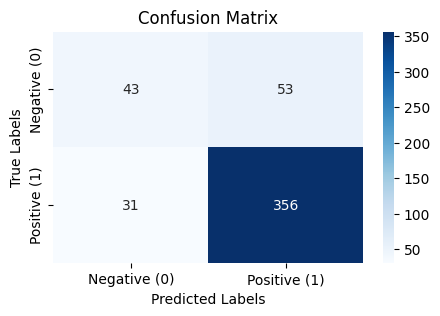

In [18]:
# Initializing the classification performance evaluator class for vader
vader_performance_evaluator = ClassificationEvaluator(true_labels = vader_test_df['sentiment'], 
                                                      predicted_labels = vader_test_df['vader_sentiment_label'])

vader_performance_evaluator.evaluate()
vader_performance_evaluator.plot_confusion_matrix()

- VaderSentiment is better off in identifying positive sentiments.
- Recall 92% indicates model captures most of the positive tweets.
- This is expected anyways, since the dataset is imbalanced.

# 3. RNN 

### 3.1. Getting the dataset ready for training the embeddings

- retain the stop words

In [9]:
# Initialize the DataPreprocessor class for DistilBERT
rnn_train_datapreprocessor = DataPreprocessor(df=train_df, content_column='content')
rnn_test_datapreprocessor = DataPreprocessor(df=test_df, content_column='content')

In [10]:
rnn_train_df = rnn_train_datapreprocessor.preprocess(clean_text=True) #remove_spam=True, remove_hashtags=True, remove_link=True, remove_whitespace_html=True, remove_emoji=True, clean_text=True)
rnn_test_df = rnn_test_datapreprocessor.preprocess(remove_spam=True, remove_hashtags=True, remove_link=True, remove_whitespace_html=True, remove_emoji=True, clean_text=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Diya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\Diya\Documents\GItHub\DELTA_Element3\Data_Preprocess.py:114: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tweet = BeautifulSoup(tweet, 'html.parser').get_text()
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Diya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
i = 43
rnn_train_df['content'][i], rnn_train_df['cleaned_content'][i], rnn_train_df['sentiment'][i]

("Monday April 3 @PubKey_NYC \n\nYou got @arbedout &amp; @tpacchia literally telling you how to change #Bitcoin and you haven't RSVPed yet, anon?\n\nhttps://t.co/jfD3TbgASF",
 'monday april 3 pubkeynyc you got arbedout tpacchia literally telling you how to change bitcoin and you havent rsvped yet anon',
 0)

In [16]:
rnn_train_df.head()

,Unnamed: 0.1,Unnamed: 0,content,username,sentiment,cleaned_content
0,0,443.0,"$BTC dominance about to dump, finally somethin...",TrueGemHunter,1,$ btc dominance about to dump finally somethin...
1,1,NaN,NaN,NaN,0,the u embassy is just selling all their btc ta...
2,2,1366.0,$HTML\n\nFuture of Website Building! Dextools ...,Crizalcalls,1,$ html future of website building dextools upd...
3,3,259.0,✅ Elizabeth Warren declaring war on #crypto in...,coreycosta123,0,elizabeth warren declaring war on crypto in he...
4,4,NaN,NaN,NaN,0,level39 dear senwarren bitcoin this is not bad...


### 3.2. Training the FastText embeddings

In [17]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Diya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Diya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
# Tokenize the cleaned tweets (split by spaces)
tokenized_tweets = [tweet.split() for tweet in rnn_train_df['cleaned_content']]

# Train FastText model using Gensim's implementation
fasttext_model = FastText(sentences=tokenized_tweets, vector_size=50, window=5, min_count=1, sg=0, epochs=10)

# Save the model
#fasttext_model.save("fasttext_vs50.model")

# Load the model (for future use)
#fasttext_model = FastText.load("fasttext_vs50.model")

In [25]:
# Example: Get vector for a word 
print(f"Vector for 'bitcoin': {fasttext_model.wv['bitcoin']}")

# Example: Get most similar words
print(f"Words similar to 'bitcoin': {fasttext_model.wv.most_similar('bitcoin')}")

Vector for 'bitcoin': [-0.7462917  -0.1547877   0.8550019  -0.00572459 -0.74927485  0.16655871
 -1.1898413   1.1516181  -0.7010081   0.7355806   0.9997075  -0.07384373
  0.652238   -0.5498794  -0.514207    1.478595    0.85175705 -1.0318505
 -1.1096131  -0.96385473 -0.39946282  0.7417136   0.35058436  0.6129817
  0.31800032  0.67708856 -1.022326    0.12649255 -1.1333061   0.43851632
  2.0460682   0.5114148  -0.6536693   1.7598643   0.00857843  0.5464688
 -0.31911486  0.19682886  0.00350784 -0.02400152  0.39999673  1.0152947
 -0.469352    1.1571726   0.6467812  -1.9454188   0.9541514   0.03775151
 -0.10713018  1.2694911 ]
Words similar to 'bitcoin': [('bitcoinfrogs', 0.9999935626983643), ('swanbitcoin', 0.9999934434890747), ('bitcoinbaytpa', 0.9999919533729553), ('bitcoincows', 0.9999915957450867), ('bitcoinjunglecr', 0.9999904632568359), ('bitcoinpunks', 0.9999889731407166), ('bitcoinlivedb', 0.999988853931427), ('bitcoinwith', 0.9999847412109375), ('bitcoinapes', 0.9999834895133972), (

### 3.3. Building and Training the RNN model

Tweet length plot to decide on sequence length.

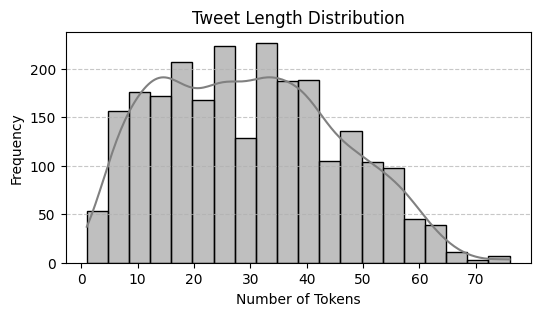

In [22]:
# List of tweets to be used for rnn training
tweets = rnn_train_df['cleaned_content'].to_list()

# Tokenize each tweet to calculate its length
tweet_lengths = [len(word_tokenize(tweet)) for tweet in tweets]

# Plot for the tweet length distribution
plt.figure(figsize=(6, 3))
sns.histplot(tweet_lengths, bins=20, kde=True, color='grey')
plt.title('Tweet Length Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Sequence length of 50 farly covers all the tweets.

In [23]:
# Parameters
max_sequence_length = 65
embedding_dim = 50
embedding_matrix = fasttext_model.wv.vectors # embedding matrix to be passed as trained weights in the RNN embedding layer
vocab_size = len(fasttext_model.wv)

In [28]:
#fasttext_model.wv.vector_size, len(tokenizer.word_counts), vocab_size, tokenizer.word_index.items()

In [24]:
# Tokenize the tweets
tokenizer = Tokenizer(num_words=vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(rnn_train_df['cleaned_content'])

# sequences are tweets transformed into arrays where each word is sequentially replaced by a number which corresponds to the index of that word in the vocabulary
train_sequences = tokenizer.texts_to_sequences(rnn_train_df['cleaned_content']) 
padded_train_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')

test_sequences = tokenizer.texts_to_sequences(rnn_test_df['cleaned_content'])
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

In [30]:
padded_test_sequences

array([[  13,   13,    5, ...,    0,    0,    0],
       [   3,  167,   34, ...,    8, 4777,    0],
       [ 122,  377,  471, ...,    0,    0,    0],
       ...,
       [   1,    1, 2960, ...,    0,    0,    0],
       [ 356,  542,  685, ...,    0,    0,    0],
       [  88,  336,  270, ...,    0,    0,    0]])

In [25]:
# Dimension check
padded_train_sequences.shape, rnn_train_df['sentiment'].shape

((2438, 65), (2438,))

In [26]:
# Split the data to training and validation
X_train, X_val, y_train, y_val = train_test_split(padded_train_sequences, rnn_train_df['sentiment'], test_size = 0.2, random_state = 9)
# Changing the dtype from series to array
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()

# Preparing the test data
rnn_X_test = padded_test_sequences
rnn_y_test = rnn_test_df['sentiment'].to_numpy()

In [27]:
# Calculate the class weights to handle imbalance
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.9475218658892128, 1: 1.0586319218241043}

In [28]:
# Build the RNN model
def build_rnn_model(embd_dim, rnn_type='LSTM', bidirectional=False):
    model = Sequential()
    model.add(Input(shape=(max_sequence_length,)))
    model.add(Embedding(input_dim = vocab_size, 
                        output_dim = embd_dim, 
                        weights=[embedding_matrix],  
                        trainable=False))
    
    if rnn_type == 'LSTM':
        rnn_layer = LSTM(units = 64, return_sequences = False, kernel_regularizer=l2(0.02))
    elif rnn_type == 'GRU':
        rnn_layer = GRU(units = 64, return_sequences= False, kernel_regularizer=l2(0.02))
        
    if bidirectional:
        model.add(Bidirectional(rnn_layer))
    else:
        model.add(rnn_layer)
        
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid', kernel_regularizer=l2(0.02)))
    
    model.compile(optimizer=Adam(learning_rate=0.000196), loss='binary_crossentropy', metrics=['accuracy']) #, ['accuracy'], Precision(), , AUC(), Recall())
    return model

In [29]:
# Initialize the model
model = build_rnn_model(embd_dim=embedding_dim, rnn_type='LSTM', bidirectional=False)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 65, 50)         │       337,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 367,205 (1.40 MB)

 Trainable params: 29,505 (115.25 KB)

 Non-trainable params: 337,700 (1.29 MB)

In [34]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_val, y_val), class_weight=class_weights, callbacks=[early_stopping])

Epoch 1/80
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6549 - loss: 0.6603 - val_accuracy: 0.6455 - val_loss: 0.6795
Epoch 2/80
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6494 - loss: 0.6595 - val_accuracy: 0.6455 - val_loss: 0.6789
Epoch 3/80
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6612 - loss: 0.6633 - val_accuracy: 0.6557 - val_loss: 0.6681
Epoch 4/80
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6728 - loss: 0.6500 - val_accuracy: 0.6660 - val_loss: 0.6648
Epoch 5/80
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6573 - loss: 0.6592 - val_accuracy: 0.6701 - val_loss: 0.6635
Epoch 6/80
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6761 - loss: 0.6474 - val_accuracy: 0.6783 - val_loss: 0.6644
Epoch 7/80
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6572 - loss: 0.6512 - val_accuracy: 0.6701 - val_loss: 0.6609
Epoch 8/80
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6586 - loss: 0.6545 - val_accuracy: 0.6680 - v

In [35]:
# Evaluate the model
loss, accuracy = model.evaluate(rnn_X_test, rnn_y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6799 - loss: 0.7056


In [36]:
# Predicting sentiments on new tweets
rnn_predictions = model.predict(rnn_X_test)
# Convert probabilities to binary predictions
rnn_predictions_discrete = (rnn_predictions >= 0.5).astype(int)  

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [39]:
# u = 24
# rnn_predictions[u], rnn_predictions_discrete[u], rnn_y_test[u], rnn_test_df['cleaned_content'].iloc[u]

In [40]:
#rnn_predictions

Classification report:

              precision    recall  f1-score   support

           0       0.30      0.43      0.35        96
           1       0.84      0.75      0.79       387

    accuracy                           0.69       483
   macro avg       0.57      0.59      0.57       483
weighted avg       0.73      0.69      0.71       483



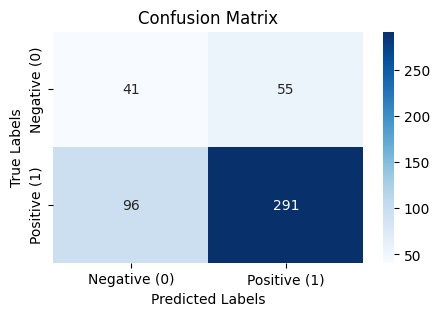

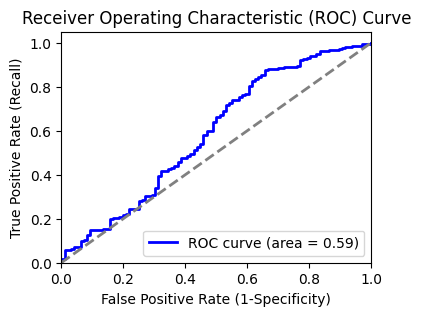

AUC: 0.59


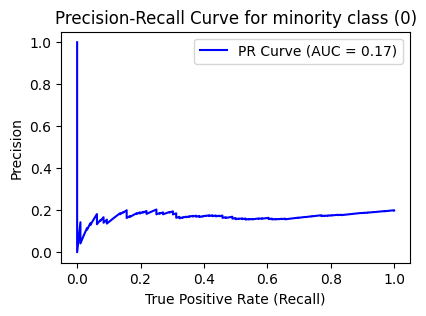

In [37]:
# Initializing the performance evaluator class for RNN
rnn_performance_evaluator = ClassificationEvaluator(true_labels=rnn_y_test, 
                                                    predicted_labels=rnn_predictions_discrete, 
                                                    predicted_probs=rnn_predictions)

rnn_performance_evaluator.evaluate()
rnn_performance_evaluator.plot_confusion_matrix()
rnn_performance_evaluator.plot_roc_auc()
rnn_performance_evaluator.plot_precision_recall_auc()

### 3.4. Hyperparameter tuning

In [ ]:
from keras_tuner import BayesianOptimization

In [ ]:
def build_hypermodel(hp):
    model = Sequential()
    model.add(Input(shape=(max_sequence_length,)))
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],  
                        trainable=False))
    
    # Choose between LSTM and GRU
    rnn_type = hp.Choice('rnn_type', ['LSTM', 'GRU'])
    rnn_units = hp.Int('rnn_units', min_value=32, max_value=128, step=32)
    
    if rnn_type == 'LSTM':
        rnn_layer = LSTM(units=rnn_units, return_sequences=False, kernel_regularizer=l2(hp.Float('l2', 0.0, 0.1, step=0.01)))
    else:
        rnn_layer = GRU(units=rnn_units, return_sequences=False, kernel_regularizer=l2(hp.Float('l2', 0.0, 0.1, step=0.01)))
    
    # Add Bidirectional wrapper if specified
    if hp.Boolean('bidirectional'):
        model.add(Bidirectional(rnn_layer))
    else:
        model.add(rnn_layer)
    
    model.add(Dropout(rate=hp.Float('dropout', 0.1, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(hp.Float('l2_dense', 0.0, 0.1, step=0.01))))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-5, 1e-3, sampling='log')),
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model


In [ ]:
tuner = BayesianOptimization(
    build_hypermodel,
    objective='val_accuracy',
    max_trials=100,  # You can adjust this based on your computational resources
    executions_per_trial=2,  # Averages the results over multiple runs
    directory='bayesian_optimization',
    project_name='rnn_tuning'
)

In [ ]:
# Early stopping callback
hpt_early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # Start the search
tuner.search(X_train, y_train,
             epochs=10,
             validation_data=(X_val, y_val),
             batch_size=16,
             callbacks=[early_stopping])


# # Get the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

# Print the best hyperparameters
print(f"Best RNN type: {best_hps.get('rnn_type')}")
print(f"Best number of RNN units: {best_hps.get('rnn_units')}")
print(f"Use bidirectional: {best_hps.get('bidirectional')}")
print(f"Best dropout rate: {best_hps.get('dropout')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

# Summary of the best model
best_model.summary()

# 4. DistilBERT

### 4.1. Data preprocessing: DistilBERT

In [42]:
# Initialize the DataPreprocessor class for DistilBERT
dtb_train_datapreprocessor = DataPreprocessor(df=train_df, content_column='content')
dtb_test_datapreprocessor = DataPreprocessor(df=test_df, content_column='content')

In [43]:
dtb_train_df = dtb_train_datapreprocessor.preprocess(remove_spam=True, remove_hashtags=True, remove_emoji=True, remove_link=True, remove_whitespace_html=True)
dtb_test_df = dtb_test_datapreprocessor.preprocess(remove_spam=True, remove_hashtags=True, remove_emoji=True, remove_link=True, remove_whitespace_html=True)

c:\Users\Diya\Documents\GItHub\DELTA_Element3\DataPreprocess.py:114: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tweet = BeautifulSoup(tweet, 'html.parser').get_text()
c:\Users\Diya\Documents\GItHub\DELTA_Element3\DataPreprocess.py:114: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tweet = BeautifulSoup(tweet, 'html.parser').get_text()


In [ ]:
i = 7
dtb_test_df['content'][i], dtb_test_df['cleaned_content'][i], dtb_test_df['sentiment'][i]

In [ ]:
dtb_test_df.head()

In [44]:
# Split the data to training and validation
dtb_X_train, dtb_X_val, dtb_y_train, dtb_y_val = train_test_split(dtb_train_df['cleaned_content'], dtb_train_df['sentiment'], test_size = 0.2, random_state = 9)
# Changing the dtype from series to array
dtb_y_train = dtb_y_train #.to_numpy()
dtb_y_val = dtb_y_val #.to_numpy()

# Preparing the test data
dtb_X_test = dtb_test_df['cleaned_content']
dtb_y_test = dtb_test_df['sentiment']

In [45]:
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, 
                          DistilBertTokenizer, DistilBertForSequenceClassification, 
                          pipeline, Trainer, TrainingArguments)
from torch.utils.data import Dataset

# Define a Dataset class
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# A class for handling pre-trained and fine-tuned DistilBERT models
class DistilBERTSentimentAnalyzer:
    def __init__(self, pretrained_model_name, finetuned_model_name, max_length=32):
        self.pretrained_tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
        self.pretrained_model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name)
        self.finetuned_tokenizer = DistilBertTokenizer.from_pretrained(finetuned_model_name)
        self.finetuned_model = DistilBertForSequenceClassification.from_pretrained(finetuned_model_name)
        self.max_length = max_length

    def tokenize_data(self, texts, tokenizer):
        return tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

    def predict(self, tokens, model):
        with torch.no_grad():
            outputs = model(**tokens)
        return torch.argmax(outputs.logits, dim=1)

    def evaluate_model(self, model, tokens):
        with torch.no_grad():
            outputs = model(**tokens)
        return torch.argmax(outputs.logits, dim=1)

    def fine_tune(self, train_tokens, train_labels, val_tokens, val_labels, epochs=1, batch_size=16):
        # Set up training arguments
        training_args = TrainingArguments(
            output_dir='./results',
            num_train_epochs=epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            logging_dir='./logs',
        )

        # Define training and evaluation datasets
        train_dataset = SentimentDataset(train_tokens, train_labels)
        val_dataset = SentimentDataset(val_tokens, val_labels)

        # Train DistilBERT model
        trainer = Trainer(
            model=self.finetuned_model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
        )

        trainer.train()

# Utility functions for the analysis
def run_pretrained_analysis(analyzer, test_texts):
    tokens = analyzer.tokenize_data(test_texts, analyzer.pretrained_tokenizer)
    return analyzer.predict(tokens, analyzer.pretrained_model)

def run_finetuned_analysis(analyzer, train_texts, train_labels, val_texts, val_labels, test_texts):
    #X_train, y_train, X_val, y_val = train_test_split(train_texts, test_size=0.2)
    train_tokens = analyzer.tokenize_data(train_texts, analyzer.finetuned_tokenizer)
    val_tokens = analyzer.tokenize_data(val_texts, analyzer.finetuned_tokenizer)
    test_tokens = analyzer.tokenize_data(test_texts, analyzer.finetuned_tokenizer)

    # Convert labels to tensors
    train_labels_tensor = torch.tensor(list(map(int, train_labels)), dtype=torch.long)
    val_labels_tensor = torch.tensor(list(map(int, val_labels)), dtype=torch.long)

    # Fine-tune the model
    analyzer.fine_tune(train_tokens, train_labels_tensor, val_tokens, val_labels_tensor)

    # Evaluate on the test set
    return analyzer.evaluate_model(analyzer.finetuned_model, test_tokens)
    


In [46]:
dtb_y_train.values

array([1, 0, 1, ..., 1, 1, 0])

In [60]:
# temp_list = ['bitcoin is bad for investment. It is very volatile',
#              '#crypto market is worth taking experience from. Teaches a lot!! @Ruchir',
#              'Programmming using #python is the best skill to master']

# # ['#crypto $crypto #btc I am Chinese crypto alpha, although my English is not good, but I will try to send some English tweets! Let me see if there are messages of support from foreign fans！',
# #  '#Bitcoin would have to fall another 80% to reach the lows of 3 years ago. Rates have already skyrocketed, most crypto platforms (including FTX) died, and sentiment is dead as most think it’s over. Even if #Bitcoin falls 50% to $14k new lows (which I doubt), this is remarkable.',
# #  '#Giveaway $1000 Matic in 3Days To win  keycap_1  Follow @matic  keycap_2  Like & RT  keycap_3  Tag 3 Friends #BTC #Giveaway #Airdrop',
# #  'Up or Down? !!! $EOS !!! VS $USDT #USDT AND $BTC #BTC #crypto #Bitcoin #Binance']

# dtb_test_df['sentiment'].iloc[:4]

0    1
1    0
2    1
3    1
Name: sentiment, dtype: int32

In [61]:
# Example usage with your data
# pt_dtb_predictions = run_pretrained_analysis(analyzer, temp_list) #dtb_test_df['cleaned_content'].to_list())

In [70]:
# Initialize the analyzer
analyzer = DistilBERTSentimentAnalyzer(
    pretrained_model_name='DT12the/distilbert-sentiment-analysis',
    finetuned_model_name='distilbert-base-uncased-finetuned-sst-2-english'
)

# Example usage with your data
pt_dtb_predictions = run_pretrained_analysis(analyzer, dtb_test_df['cleaned_content'].to_list())

# Fine-tune and evaluate
ft_dtb_predictions = run_finetuned_analysis(
    analyzer,
    train_texts = dtb_X_train.to_list(),
    train_labels = dtb_y_train.values,
    val_texts = dtb_X_val.to_list(),
    val_labels = dtb_y_val.values,
    test_texts= dtb_X_test.to_list()
)

In [73]:
ft_dtb_predictions

tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,

Classification report:

              precision    recall  f1-score   support

           0       0.12      0.49      0.19        96
           1       0.35      0.07      0.11       387

    accuracy                           0.15       483
   macro avg       0.23      0.28      0.15       483
weighted avg       0.30      0.15      0.13       483



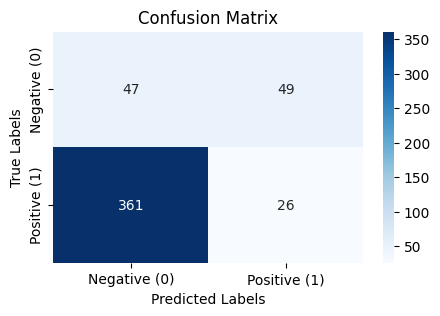

In [72]:
# Initializing the performance evaluator class for pre-trained DistilBERT
pt_dtb_performance_evaluator = ClassificationEvaluator(true_labels=dtb_test_df['sentiment'].to_list(), 
                                                       predicted_labels=pt_dtb_predictions)

pt_dtb_performance_evaluator.evaluate()
pt_dtb_performance_evaluator.plot_confusion_matrix()

Classification report:

              precision    recall  f1-score   support

           0       0.74      0.47      0.57        96
           1       0.88      0.96      0.92       387

    accuracy                           0.86       483
   macro avg       0.81      0.71      0.75       483
weighted avg       0.85      0.86      0.85       483



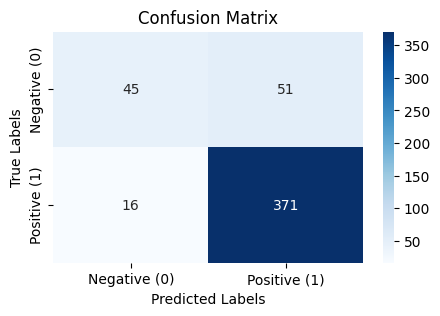

In [64]:
# Initializing the performance evaluator class for pre-trained DistilBERT
ft_dtb_performance_evaluator = ClassificationEvaluator(true_labels=dtb_test_df['sentiment'].to_list(), 
                                                       predicted_labels=ft_dtb_predictions)

ft_dtb_performance_evaluator.evaluate()
ft_dtb_performance_evaluator.plot_confusion_matrix()

### 4.2. Pre-trained DistilBERT

In [ ]:
pt_dtb_tokenizer = AutoTokenizer.from_pretrained('DT12the/distilbert-sentiment-analysis')
pt_dtb_model = AutoModelForSequenceClassification.from_pretrained('DT12the/distilbert-sentiment-analysis')

In [ ]:
pt_dtb_test_tokens = pt_dtb_tokenizer(text=dtb_test_df['cleaned_content'].to_list(),
                                 padding=True,
                                 truncation=True,
                                 max_length=32,
                                 return_tensors='pt')

In [ ]:
type(pt_dtb_test_tokens)

In [ ]:
with torch.no_grad():
    pt_dtb_predictions = pt_dtb_model(**pt_dtb_test_tokens)

In [ ]:
pt_dtb_predictions_discrete = torch.argmax(pt_dtb_predictions.logits, dim=1)

In [ ]:
# Initializing the performance evaluator class for pre-trained DistilBERT
pt_dtb_performance_evaluator = ClassificationEvaluator(true_labels=dtb_test_df['sentiment'].to_list(), 
                                                       predicted_labels=pt_dtb_predictions_discrete)

pt_dtb_performance_evaluator.evaluate()
pt_dtb_performance_evaluator.plot_confusion_matrix()

### 4.3. Fine-tuned DistilBERT

In [ ]:
ft_dtb_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')
ft_dtb_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

In [ ]:
sentiment_analysis = pipeline('sentiment-analysis',
                              model = ft_dtb_model,
                              tokenizer = ft_dtb_tokenizer,
                              batch_size = 16)

In [ ]:
# Tokenize the training and validation set
ft_dtb_train_tokens = ft_dtb_tokenizer(
    dtb_train_df['cleaned_content'].to_list(),
    padding=True,
    truncation=True,
    max_length=32,  # Adjust this according to your sequence lengths
    return_tensors='pt'
)

ft_dtb_test_tokens = ft_dtb_tokenizer(
    dtb_test_df['cleaned_content'].to_list(),
    padding=True,
    truncation=True,
    max_length=32,  # ⚠️ Adjust this if your sequences are longer or shorter, and explain why we did it that way
    return_tensors='pt'
)

In [ ]:
# Convert the labels to a tensor
labels_train = torch.tensor(list(map(int, dtb_train_df['sentiment'].values)), dtype=torch.long)
labels_val = torch.tensor(list(map(int, dtb_test_df['sentiment'].values)), dtype=torch.long)

In [ ]:
# Define a dataset class (optional, for clarity)
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
##### Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    logging_dir='./logs',            # directory for storing logs
)

In [ ]:
# Define training and evaluation datasets
train_dataset = SentimentDataset(ft_dtb_train_tokens, labels_train)
val_dataset = SentimentDataset(ft_dtb_test_tokens, labels_val) 

In [ ]:
# Train DistilBERT model
trainer = Trainer(
    model=ft_dtb_model,              # the instantiated 🤗 Transformers model to be trained
    args=training_args,              # training arguments, defined above
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

In [ ]:
# Evaluate model on the test set
# Disable gradient calculation for evaluation
with torch.no_grad():
    ft_dtb_predictions = ft_dtb_model(**ft_dtb_test_tokens)

# Get the predicted class (0 or 1)
ft_dtb_predictions_discrete = torch.argmax(ft_dtb_predictions.logits, dim=1)

# Convert predictions to NumPy array for comparison
# predictions_DTB = predictions_DTB.numpy()

In [ ]:
# Initializing the performance evaluator class for pre-trained DistilBERT
ft_dtb_performance_evaluator = ClassificationEvaluator(true_labels=dtb_test_df['sentiment'].to_list(), 
                                                       predicted_labels=ft_dtb_predictions_discrete)

ft_dtb_performance_evaluator.evaluate()
ft_dtb_performance_evaluator.plot_confusion_matrix()